In [1]:
import json
import math
import random
from pathlib import Path
from pprint import pprint
from utils import load_dataset, create_dataset, write_test_data, gpt_prediction, eval_response, results_path

output_dir = results_path / "sentence_length_tiled"
if not output_dir.exists():
    output_dir.mkdir(parents=True)
dataset, tag_counts = load_dataset("sentences.json")
print(len(dataset))
pprint(tag_counts)

200
{'all_lower': 78,
 'all_upper': 59,
 'animate': 1,
 'city': 25,
 'even_words': 97,
 'fragment_subject': 20,
 'fragment_verb': 20,
 'gpt4': 200,
 'long': 108,
 'nature': 62,
 'odd_words': 103,
 'proper_noun': 32,
 'sentence': 160,
 'shared_sample': 42,
 'short': 92,
 'start_cap': 121,
 'start_consonant': 171,
 'start_lower': 79,
 'start_the': 57,
 'start_vowel': 29}


In [2]:
# fragments vs sentence; just subject/verb fragments vs all; test if class balance changes accuracy
tags_true = ["short"]
tags_false = ["long"]
tags_common = []
positives, negatives = create_dataset(dataset, tags_true, tags_false, tags_common, true_comb="AND", false_comb="AND")

with open(output_dir / "dataset_tags.txt", "w") as f:
    f.write(f"tags_true: {tags_true}\n")
    f.write(f"tags_false: {tags_false}\n")
    f.write(f"tags_common: {tags_common}\n")

print(len(positives), len(negatives))

92 108


In [3]:
pprint(positives)

[{'input': 'always strive for excellence.',
  'label': True,
  'tags': ['gpt4',
           'sentence',
           'even_words',
           'short',
           'start_vowel',
           'all_lower',
           'start_lower',
           'shared_sample']},
 {'input': 'Ancient ruins from a forgotten civilization',
  'label': True,
  'tags': ['gpt4',
           'even_words',
           'short',
           'fragment_subject',
           'start_vowel',
           'start_cap']},
 {'input': 'SCIENCE AND TECHNOLOGY ARE DRIVING INNOVATION.',
  'label': True,
  'tags': ['all_upper',
           'gpt4',
           'sentence',
           'even_words',
           'short',
           'start_consonant',
           'start_cap',
           'shared_sample']},
 {'input': 'the wind gently rustles the leaves.',
  'label': True,
  'tags': ['gpt4',
           'sentence',
           'even_words',
           'short',
           'nature',
           'start_consonant',
           'all_lower',
           'start_the'

In [4]:
pprint(negatives)

[{'input': 'the moonlight casts a glow over the night.',
  'label': False,
  'tags': ['gpt4',
           'sentence',
           'even_words',
           'nature',
           'start_consonant',
           'long',
           'all_lower',
           'start_the',
           'start_lower',
           'shared_sample']},
 {'input': 'happiness is a warm cup of tea.',
  'label': False,
  'tags': ['gpt4',
           'sentence',
           'start_consonant',
           'long',
           'odd_words',
           'all_lower',
           'start_lower',
           'shared_sample']},
 {'input': 'The bustling city streets echoed with the sounds of honking horns '
           'and hurried footsteps.',
  'label': False,
  'tags': ['gpt4',
           'city',
           'sentence',
           'even_words',
           'start_consonant',
           'long',
           'start_cap',
           'start_the']},
 {'input': 'i enjoy hiking in the peaceful woods.',
  'label': False,
  'tags': ['gpt4',
           'sent

In [6]:
sample_counts = [3, 5, 10, 15]
response_jsons = []
for c in sample_counts:
    write_test_data(positives, negatives, c, output_dir, tiled=True)
    in_context_prompt = open(output_dir / f"in_context_prompt_{c}.txt").read()
    test_prompt = open(output_dir / f"test_prompt_{c}.txt").read()
    test_samples = json.load(open(output_dir / f"test_samples_{c}.json"))
    response_json = gpt_prediction(in_context_prompt, test_prompt, json_mode=True)
    json.dump(response_json, open(output_dir / f"response_{c}.json", "w"))
    response_jsons.append(response_json)

/Users/ishangaur/classification-faithfulness/utils.py:106: UserWarning: json_mode only supported for gpt-4-1106-preview
  warn("json_mode only supported for gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:107: UserWarning: changing model to gpt-4-1106-preview
  warn("changing model to gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:110: UserWarning: json_mode is on but user_query does not contain "json"
  warn("json_mode is on but user_query does not contain \"json\"")
/Users/ishangaur/classification-faithfulness/utils.py:111: UserWarning: adding prefix to user_query:
"Please label the following inputs. Respond in JSON format like the examples given to you above."
  warn(f"adding prefix to user_query:\n\"{json_prefix}\"")
/Users/ishangaur/classification-faithfulness/utils.py:106: UserWarning: json_mode only supported for gpt-4-1106-preview
  warn("json_mode only supported for gpt-4-1106-preview")
/Users/ishangaur/classification-fait

In [7]:
sample_counts = [3, 5, 10, 15]
response_jsons = [json.load(open(output_dir / f"response_{c}.json")) for c in sample_counts]
test_samples = [json.load(open(output_dir / f"test_samples_{c}.json")) for c in sample_counts]

results = []
responses = []
for r, t in zip(response_jsons, test_samples):
    response, result = eval_response(r, t)
    results.append(result)
    responses.append(response)

In [8]:
for c, r in zip(sample_counts, results):
    r["in_context_count"] = c
pprint(results)

[{'accuracy': 0.5955056179775281,
  'correct': 106,
  'corrupted': 0,
  'in_context_count': 3,
  'incorrect': 72,
  'mismatch': 0,
  'total': 178},
 {'accuracy': 0.6149425287356322,
  'correct': 107,
  'corrupted': 0,
  'in_context_count': 5,
  'incorrect': 67,
  'mismatch': 0,
  'total': 174},
 {'accuracy': 0.5426829268292683,
  'correct': 89,
  'corrupted': 0,
  'in_context_count': 10,
  'incorrect': 75,
  'mismatch': 0,
  'total': 164},
 {'accuracy': 0.5,
  'correct': 77,
  'corrupted': 0,
  'in_context_count': 15,
  'incorrect': 77,
  'mismatch': 0,
  'total': 154}]


In [9]:
json.dump(responses, open(output_dir / "responses.json", "w"))
json.dump(results, open(output_dir / "results.json", "w"))

                   correct  mismatch  incorrect  corrupted  test_total
in_context_count                                                      
3                 0.595506       0.0   0.404494        0.0    0.983425
5                 0.614943       0.0   0.385057        0.0    0.961326
10                0.542683       0.0   0.457317        0.0    0.906077
15                0.500000       0.0   0.500000        0.0    0.850829


Text(0.5, 1.0, 'Short (<7) vs Long Tiled (n=181, T=1)')

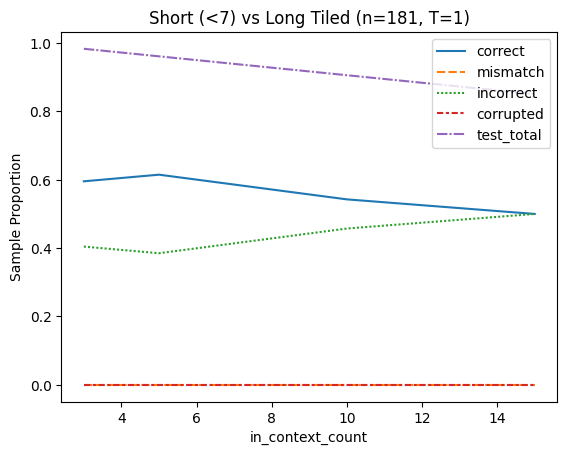

In [10]:
import pandas as pd
import seaborn as sns

results = json.load(open(output_dir / "results.json"))

df = pd.DataFrame(results)
df.drop(columns=["accuracy"], inplace=True)
total_samples = df["total"].max() + df["in_context_count"].min()

for col in df.columns:
    if col == "total":
        df[col] /= total_samples
    elif col == "in_context_count":
        continue
    else:
        df[col] /= df["total"]
df["test_total"] = df["total"]
df.drop(columns=["total"], inplace=True)
df.set_index("in_context_count", inplace=True)
print(df)

ax = sns.lineplot(data=df)
ax.set_ylabel("Sample Proportion")
ax.set_title(f"Short (<7) vs Long Tiled (n={total_samples}, T=1)")